# Выявление закономерностей, определяющих успешность компютерной игры

<font size=4>
Перед нами исторические открытые данные до 2016 года о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы. Нам необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.
</font>

## Подключение библиотек

In [1]:
import os

import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math 
import warnings

warnings.filterwarnings("ignore")

PATH = 'C:/Users/igors/OneDrive/Рабочий стол/Портфолио/4. Исследование успешности компьютерных игр/games.csv'

## Изучение общей информации о данных

In [2]:
if os.path.exists(PATH):
    try:
        data = pd.read_csv(PATH)
    except:
        print('Ошибка в считывании данных.')
else:
    print(f'Путь {PATH} не сущесвтует.')


display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Описание данных**

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
display(data.isna().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [5]:
display(data.duplicated().sum())

0

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


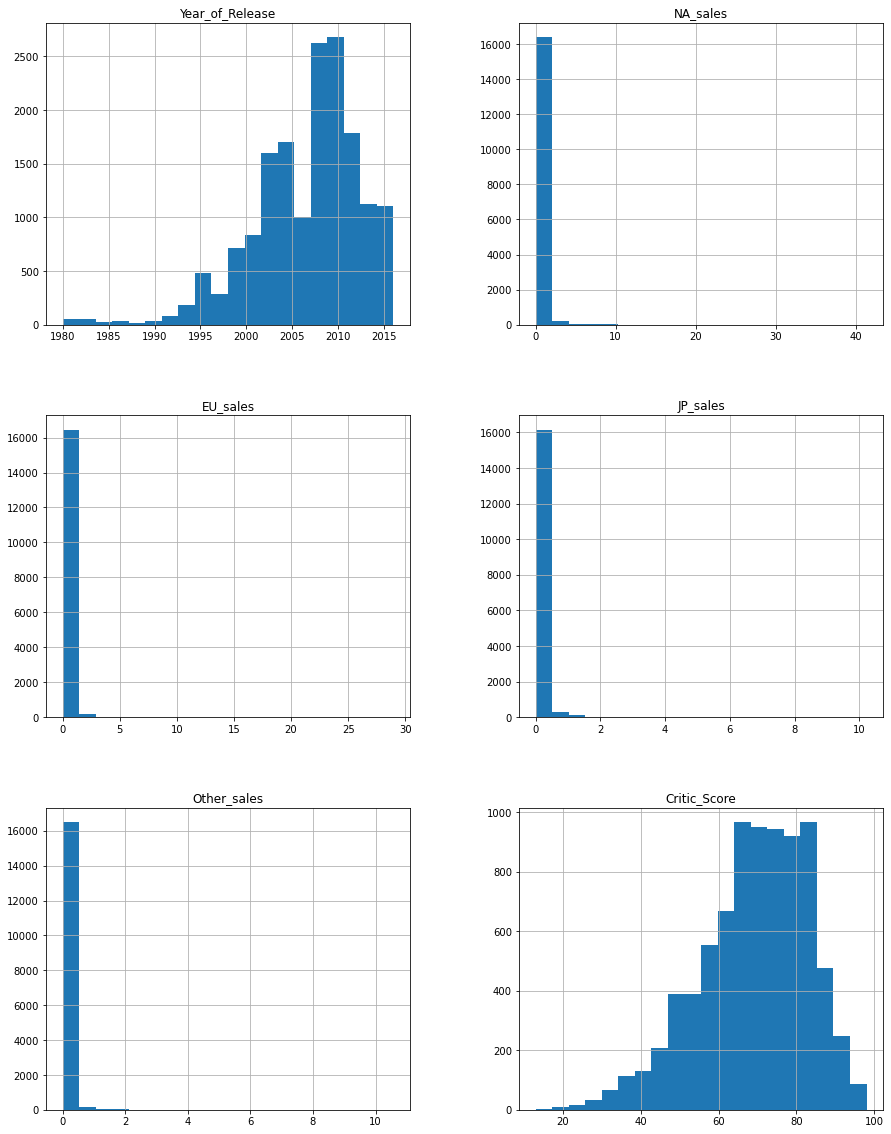

In [6]:
data.hist(bins=20, figsize=(15, 20))
data.describe()

### Выводы

<font size=4>
    
- Названия столбцов стилистически оформлены неверно — необходимо привести их к нижнему регистру.
- У некоторых столбцов неверный тип данных:

|Название столбца|текущий тип данных|корректный тип данных|
|:---|:---|:---|
|Year_of_Release|float64|int64|
|User_Score|object|float64|

- В столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating` обнаружены пропуски, причём в последних трёх - существенное по сравнению с размером датафрейма количество.
- По гистограммам можно заметить, что существует значительный разрыв в количестве продаж между играми.
- Явных дубликатов не обнаружено, но стоит отдельно поработать со столбцом с названиями игр.
    
</font>

## Предобработка данных

**Порядок предобработки** 

|Порядок|вид предобработки|причина|
|:---|:---|:---|
|1|переименование колонок датафрейма|удобство работы с колонками в последующих пунктах|
|2|обработка дубликатов в столбце с названиями игр|если будут найдены и удалены дубликаты, в следующих пунктах придётся обрабатывать меньше строк — это уменьшит вычислительную нагрузку|
|3|изменение типов данных столбцов|с некорректными типами данных будет очень сложно или невозможно обработать некоторые аномальные значения: например, не получится использовать статистики для оценки аномальных значений, если столбец имеет тип `object`|
|4|обработка аномальных значений|возможно, позволит отбросить некоторые строки перед обработкой пропусков и тем самым уменьшить вычислительную нагрузку; заметим, что в ходе корректной обработки пропусков нельзя получить новое аномальное значение|
|5|обработка пропусков|самый ёмкий с точки зрения вычислений этап, поэтому важно отбросить все некорретные строки до него|  
|6|добавление столбцов|к данному этапу лучше всего приступать, когда остальные уже проделаны, т.к. могут понадобиться данные, полученные на более ранних этапах| 
    


### Переименование колонок датафрейма

In [7]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
data = data.rename(columns={key: key.lower() for key in data.columns})
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка дубликатов в столбце с названиями игр 

In [9]:
display(data['name'].duplicated().sum())

5155

**Дубликатов в столбце с названиями игр очень много. Попробуем понять, в чём причина. Для этого выведем срез дубликатов, отсортированный по названию игры**

In [10]:
display(data[data['name'].duplicated(keep=False)].sort_values('name'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
3358,Frozen: Olaf's Quest,3DS,2013.0,Platform,0.27,0.27,0.00,0.05,NaN,NaN,NaN
14658,007: Quantum of Solace,PC,2008.0,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
9507,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
3120,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
12648,pro evolution soccer 2011,PC,2010.0,Sports,0.00,0.05,0.00,0.01,79.0,NaN,NaN
15612,uDraw Studio: Instant Artist,X360,2011.0,Misc,0.01,0.01,0.00,0.00,54.0,5.7,E
8280,uDraw Studio: Instant Artist,Wii,2011.0,Misc,0.06,0.09,0.00,0.02,NaN,tbd,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN


**Для одной и той же игры, вышедшей на n разных платформах, в таблице n строк. Проверим, есть ли дубликаты по двум столбцам, `name` и `platform`.**

In [11]:
display(data.duplicated(['name', 'platform']).sum())

5

**Дубликатов осталось всего 5. Рассмотрим их внимательнее.**

In [12]:
display(data[data.duplicated(['name', 'platform'], keep=False)].sort_values(['name', 'year_of_release']))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Можно заметить, что почти у всех оставшихся дубликатов совпадают год релиза, оценки критиков, игроков и возрастной рейтинг. Скорее всего, это означает, что дублирующиеся строки появились только из-за неверной записи продаж — сложим для таких дубликатов столбцы с продажами и оставим только одну строку. Исключением является игра "Need for Speed: Most Wanted", у которой есть строки с разными годами релиза. С помощью интернета можно устанвоить, что это две разные игры, несмотря на одинаковые оценки и рейтинг. Чтобы избавиться от данного "дубликата" изменим название "Need for Speed: Most Wanted" вышедшей в 2012 году на "Need for Speed: Most Wanted (2012)". Что касается игры без названия, о ней в таблице мало данных, к тому же она выпущена в 1993 году и вряд ли попадёт в актуальный период, с играми из которого предстоит работать далее, поэтому просто удалим строки с ней из таблицы.


In [13]:
data = data.dropna(subset=['name'])
data.loc[(data['name'] == 'Need for Speed: Most Wanted') &\
         (data['year_of_release'] == 2012.0), \
         'name'] = 'Need for Speed: Most Wanted (2012)'

In [14]:
sum_sales = data.loc[data.duplicated(['name', 'platform'], keep=False)].groupby(['name', 'platform'], as_index=False)\
        ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'].sum()
sum_sales['index'] = data.loc[(data.duplicated(['name', 'platform'], keep=False) &
        ~(data.duplicated(['name', 'platform'], keep='first')),\
        'eu_sales')].index
sum_sales = sum_sales.set_index('index')
data.loc[(data.duplicated(['name', 'platform'], keep=False) &
        ~(data.duplicated(['name', 'platform'], keep='first')),\
        ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])] = sum_sales['eu_sales']

**Убедимся, что сумма продаж по регинам попала в первую строку.**

In [15]:
display(data[data.duplicated(['name', 'platform'], keep=False)].sort_values(['name', 'year_of_release']))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,0.23,0.23,0.23,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.54,0.54,0.54,0.54,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


**Удалим дубликаты**

In [16]:
data = data.drop_duplicates(subset=['name', 'platform']).reset_index(drop=True)

### Изменение типов данных столбцов

**Изменим тип данных столбца `year_of_release` на int64 , а столбца `user_score` на float64.**

In [17]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['user_score'] = data['user_score'].astype('float')

ValueError: could not convert string to float: 'tbd'

Сообщение об ошибке позволяте понять, что в столбце есть значение `'user_score'` 'tbd', которое не позволяет изменить тип данных. TBD — это аббревиатура фразы "to be determined", которая переводится как "будет определено". В нашем случае эту фразу стоит заменить на NaN. Но для начала выведем список уникалльных значений столбца `'user_score'`, чтобы увидеть, если ли там другие строковые значения, которые нельзя конвертировать во float.

In [18]:
print(data['user_score'].sort_values().unique())

['0' '0.2' '0.3' '0.5' '0.6' '0.7' '0.9' '1' '1.1' '1.2' '1.3' '1.4' '1.5'
 '1.6' '1.7' '1.8' '1.9' '2' '2.1' '2.2' '2.3' '2.4' '2.5' '2.6' '2.7'
 '2.8' '2.9' '3' '3.1' '3.2' '3.3' '3.4' '3.5' '3.6' '3.7' '3.8' '3.9' '4'
 '4.1' '4.2' '4.3' '4.4' '4.5' '4.6' '4.7' '4.8' '4.9' '5' '5.1' '5.2'
 '5.3' '5.4' '5.5' '5.6' '5.7' '5.8' '5.9' '6' '6.1' '6.2' '6.3' '6.4'
 '6.5' '6.6' '6.7' '6.8' '6.9' '7' '7.1' '7.2' '7.3' '7.4' '7.5' '7.6'
 '7.7' '7.8' '7.9' '8' '8.1' '8.2' '8.3' '8.4' '8.5' '8.6' '8.7' '8.8'
 '8.9' '9' '9.1' '9.2' '9.3' '9.4' '9.5' '9.6' '9.7' 'tbd' nan]


Других таких значений нет.

In [19]:
data['user_score'] = data['user_score'].replace({'tbd': np.nan})

**Изменим тип данных столбца `user_score` на float64.**

In [20]:
data['user_score'] = data['user_score'].astype('float')

**Убедимся, что столбцы имеют верные типы данных.**

In [21]:
display(data.head())
data.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16711 entries, 0 to 16710
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8135 non-null   float64
 9   user_score       7588 non-null   float64
 10  rating           9947 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


### Обработка аномальных значений 

**Попробуем найти аномальные значения в столбцах `year_of_release`, `na_sales`, `eu_sales	`, `jp_sales`, `other_sales`, `critic_score`, `user_score`.**

In [22]:
display(data['year_of_release'].sort_values().unique())
print(data[data['na_sales'] < 0]['na_sales'].count())
print(data[data['eu_sales'] < 0]['na_sales'].count())
print(data[data['jp_sales'] < 0]['na_sales'].count())
print(data[data['other_sales'] < 0]['na_sales'].count())
print(data[(data['critic_score'] < 0) | (data['critic_score'] > 100)]['na_sales'].count())
print(data[(data['user_score'] < 0) | (data['user_score'] > 10)]['na_sales'].count())

<IntegerArray>
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, <NA>]
Length: 38, dtype: Int64

0
0
0
0
0
0


**Аномальных значений не обнаружено.**

### Обработка пропусков

**Ещё раз выведем информацию о пропусках в столбцах.**

In [23]:
display(data.isna().sum())

name                  0
platform              0
year_of_release     268
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

|Название столбца|описание данных|возможная причина пропуска|комментарий насчёт заполнения|
|:---|:---|:---|:---|
|year_of_release|год выпуска| - |нельзя предложить хороший способ заполнения|
|critic_score|оценка критиков|информации об игре нет на агрегаторах рейтинга|любой рейтинг очень субъективен; часто на агрегаторах рейтинга возникает ситуация, где рейтинг критиков сильно расходится с рейтингом игроков; к сожалению, данный параметр строится на основе вкуса и ощущений критика/игрока, а не на основе объективных метрик, поэтому рассчитать рейтинг при помощи компьютера крайне сложно. Что касается текущего проекта, стоит отметить, что пропуски в последних трёх строках составляют примерно от 40% до 55%, поэтому при попытке заполнения пропусков выборочным средним или выборочной медианой реальная картина может сильно исказиться|
|user_score|оценка пользователей|информации об игре нет на агрегаторах рейтинга| - |
|rating|рейтинг ESRB|не является обязательным для игры| переменная является категориальной, что позволяет выделить строки с пропущенными значениями в отдельную категорию |

**Чтобы не потерять информацию о данных с пропусками в возростном рейтинге, выделим их в категорию 'unknown'.**

In [24]:
data['rating'] = data['rating'].fillna('unknown')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown


### Работа с категориями в стобце `rating`

**Посмотрим, как много представительей различный хатегорий в столбце `rating`.**

In [25]:
data.groupby('rating')['rating'].count()

rating
AO            1
E          3989
E10+       1419
EC            8
K-A           3
M          1563
RP            3
T          2961
unknown    6764
Name: rating, dtype: int64

Заметим, что есть несколько видов рейтинга с малочислеными представтелями.
- Рейтинг **AO** (Adults Only 18+) можно заменить на **M**.
- Рейтинг **EC** (Early childhood) можно заменить на **E**
- Рейтинг **RP** (Rating Pending) можно заменить на **unknown**
- Рейтинг **K-A**  - это, вероятно, устаревшее название для рейтинга **E**.

In [26]:
data['rating'] = data['rating'].replace({'AO':'M', 'EC':'E', 'RP':'unknown', 'K-A':'E'}) 
data.groupby('rating')['rating'].count()

rating
E          4000
E10+       1419
M          1564
T          2961
unknown    6767
Name: rating, dtype: int64

### Добавление столбцов

**Для удобства дальнейшей работы добавим столбец с общими продажами для каждой игры по каждой платформе.**

In [27]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis=1)
display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


<font size = 4>
    <b>Датафрейм готов к дальнейшей работе</b>
</font>

## Исследовательский анализ данных

### Определение актуальных данных и перспективных платформ

**Рассмотрим, сколько игр выпускалось в разные годы. Сделаем доплнительный датафрейм, содержащий информацию о названии игры и годе выпуска.**

In [28]:
data_name_year = data[['name', 'year_of_release']].drop_duplicates()
len(data_name_year)

12426

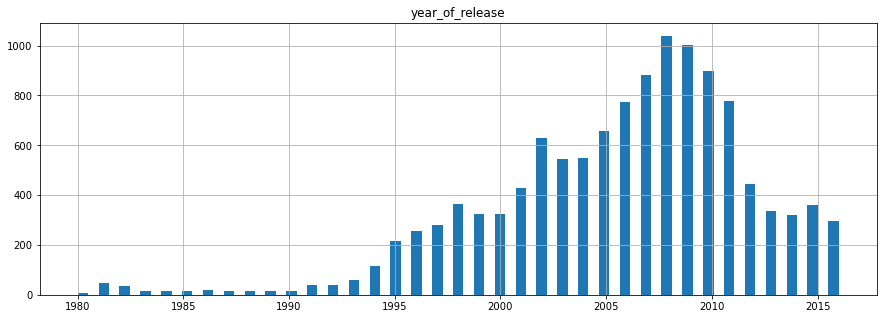

In [29]:
data_name_year.hist('year_of_release', bins=73, figsize=(15,5))
plt.show()

По графику можно заметить, что количество игр в среднем увеличивалось с 1992 по 2008 год, но дальше стремительно пошло на спад. Возможно, это говорит о количественно-качественном переходе.

**Посмотрим, как менялись продажи по платформам. Для начала выделим 10 платформ с наибольшим суммарным количеством продаж.**

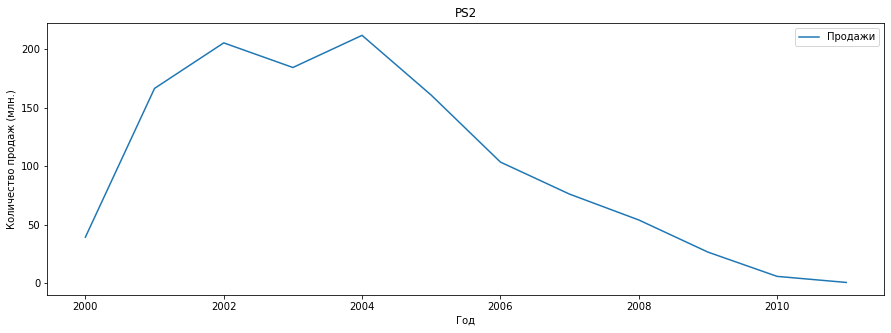

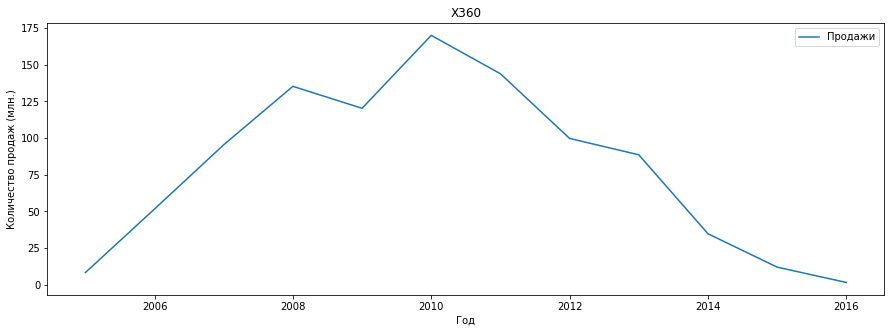

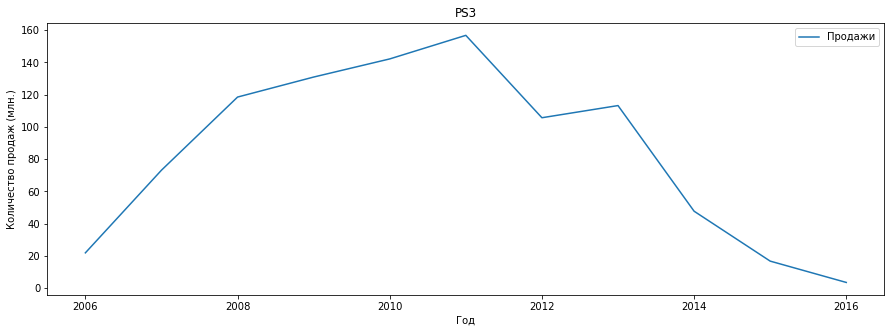

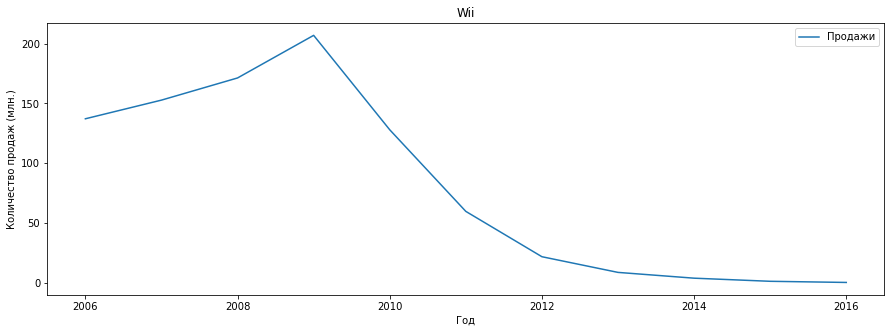

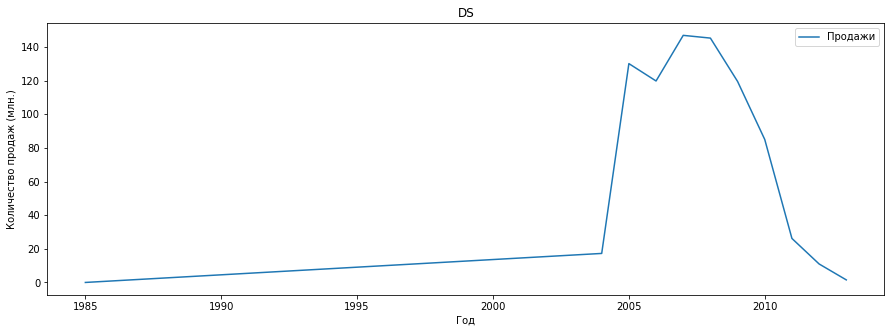

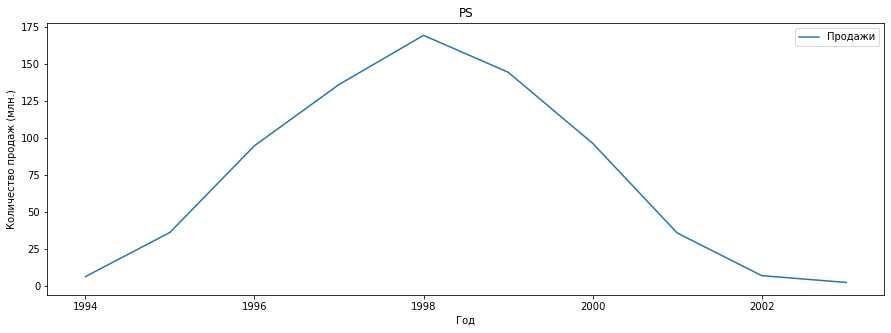

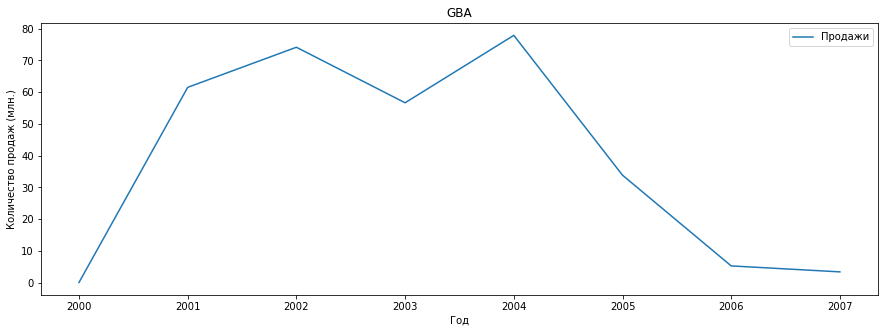

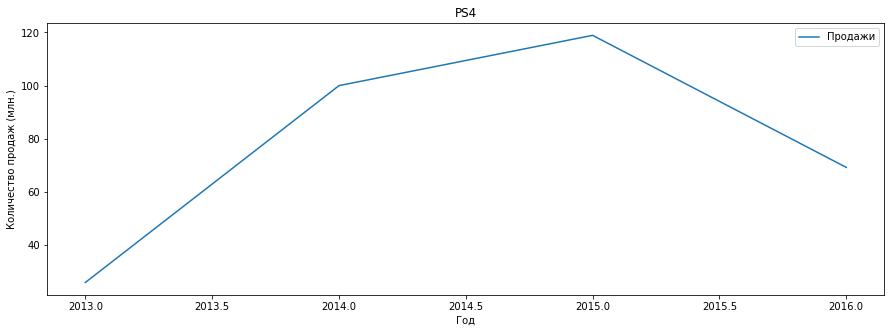

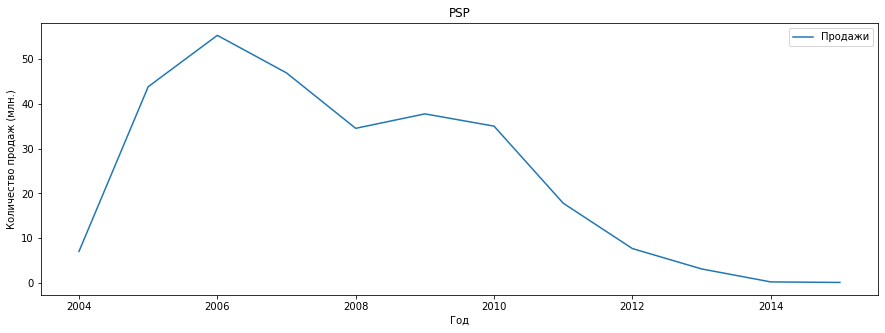

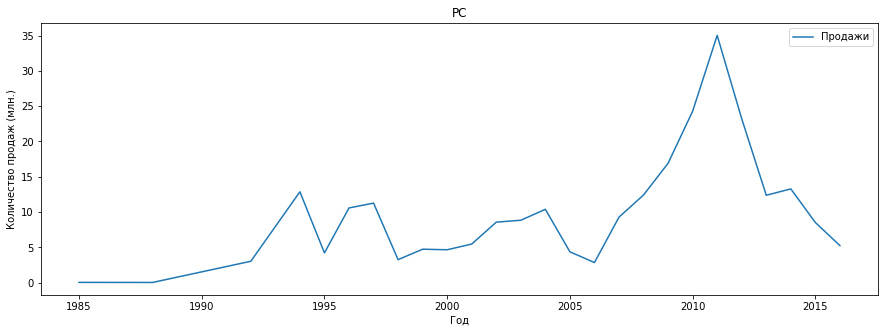

In [30]:
data_platforms = (
    data.groupby(['platform'], as_index=False)['total_sales'].sum()\
    .sort_values('total_sales', ascending=False).head(10).reset_index(drop=True)
)

data_platforms_years = data.groupby(['platform', 'year_of_release'], as_index=False)['total_sales'].sum()


for platform in data_platforms['platform'].unique():
    data_platforms_years[data_platforms_years['platform'] == platform].plot(x='year_of_release', xlabel= 'Год', y='total_sales', ylabel='Количество продаж (млн.)', label='Продажи', title=platform, figsize=(15,5))
    plt.title = platform
    plt.show()


In [31]:
data.groupby('platform').agg(first_year=('year_of_release', 'min'), last_year=('year_of_release', 'max')).sort_values('platform')


,first_year,last_year
platform,,
2600,1980,1989
3DO,1994,1995
3DS,2011,2016
DC,1998,2008
DS,1985,2013
GB,1988,2001
GBA,2000,2007
GC,2001,2007
GEN,1990,1994


По таблице видно, что чаще всего платформы живут 5-10 лет. Некоторые компании обновляют свою платформу примерно раз в 6 лет для поддержания своей популярности.

**Актуальными будем считать данными за 2015-2016 годы. Именно они должны помочь построить прогноз на 2017 год.**

In [32]:
data = data[(data['year_of_release'] >= 2015) & (data['year_of_release'] <= 2016)]

**Рассмотрим платформы, актуальные для выбранного периода, и постараемся выбрать несколько потенциально прибыльных. Используем сводную таблицу для построения графика. Графие построим по медианным значениям продаж, так как некоторые "крупные" игры могли выйти на малом количестве платформ, что искажает реальную картину.**

<AxesSubplot:title={'center':'Динамика продаж игр на различных платформах за 2015-2016 годы'}, xlabel='Год', ylabel='Продажи (млн.)'>

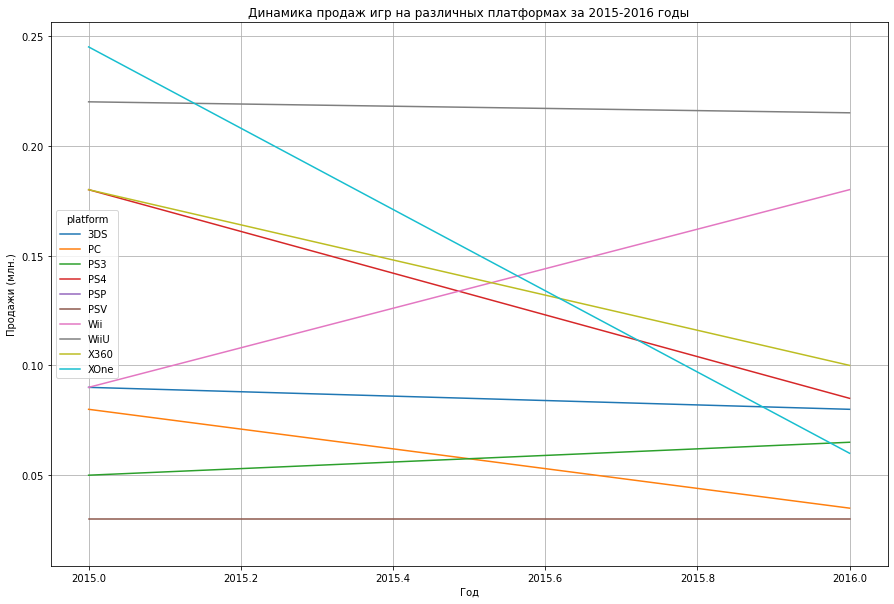

In [33]:
pd.pivot_table(data, index='year_of_release', columns='platform', values='total_sales', aggfunc='median')\
.plot(grid=True, figsize=(15,10), xlabel='Год', ylabel='Продажи (млн.)', title='Динамика продаж игр на различных платформах за 2015-2016 годы')

По графику видно, что многие платформы падают по продажам. Тем не менее, на данный момент со значительным отрывом лидируют **WiiU** и **Wii**, на третьем месте **XOne** — будем считать их **потенциально прибыльными**.

In [34]:
popular_platforms = ['WiiU', 'Wii', 'XOne']
popular_platform_data = data.query('platform == @popular_platforms')

**Построим ящики с усами по общим продажам для каждой платформы и в отдельной таблице детальнее опишем статистики выборки.**

<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

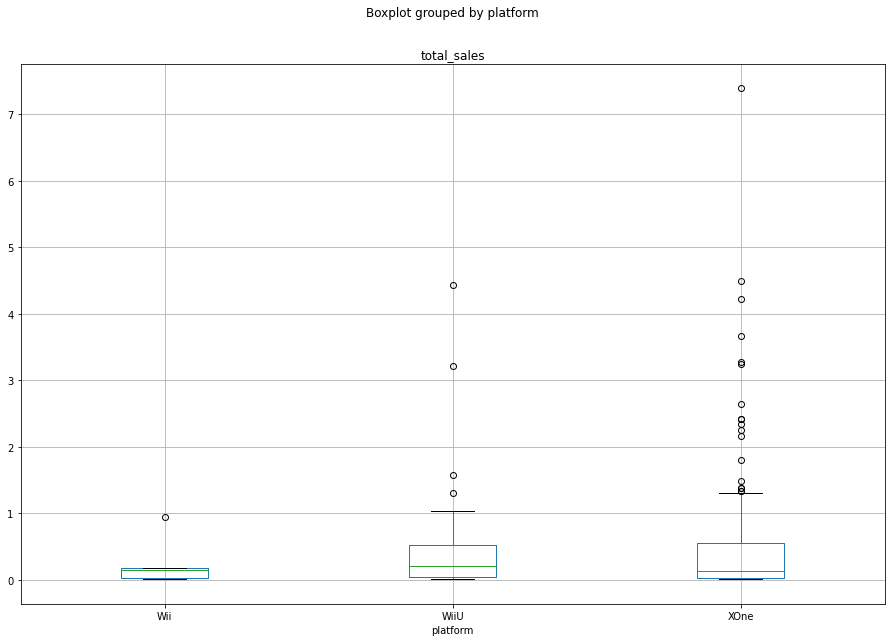

In [35]:
popular_platform_data.boxplot('total_sales', by='platform', figsize=(15,10))


**По данной диаграмме размаха хорошо видно, что в выборках по платформам достаточно много выбросов, но не очень хорошо видны статистики. Построим более наглядную диаграмму.**

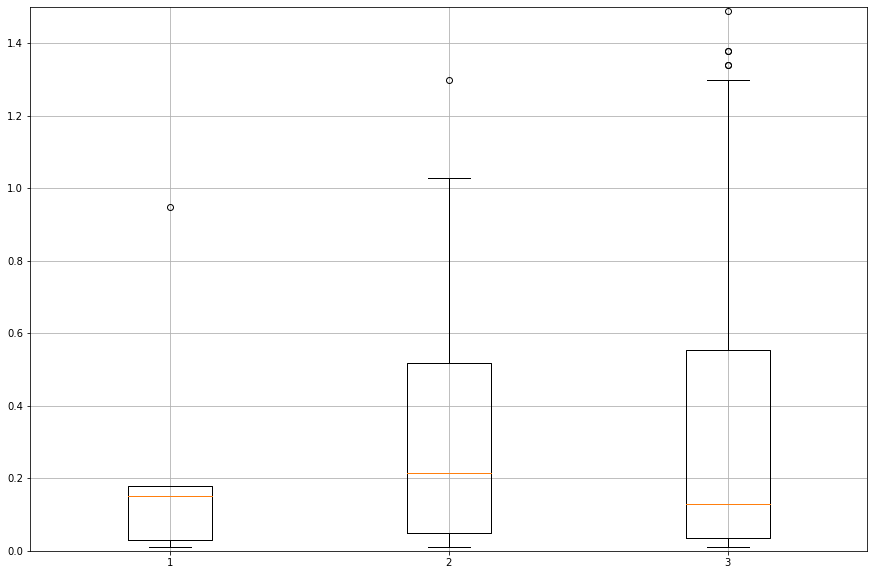

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot([popular_platform_data[popular_platform_data['platform'] == platform]['total_sales'] for platform in ['Wii', 'WiiU', 'XOne']])
ax.set_ylim(0, 1.5)
ax.grid()
plt.show()

In [37]:
popular_platform_data.groupby('platform')['total_sales'].describe().sort_values('50%', ascending=False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
WiiU,42.0,0.498810,0.850240,0.01,0.050,0.215,0.5175,4.44
Wii,5.0,0.264000,0.390487,0.01,0.030,0.150,0.1800,0.95
XOne,167.0,0.516707,0.965940,0.01,0.035,0.130,0.5550,7.39


Описание статистик позволяет понять, что из-за выбросов очень велика разница между третим кваритлем и максимальным значением в каждой выборке. В таком случае в дальнейших исследованиях лучше ориентироваться не на средние, а на медианные значения в каждой выборке. Согласно последним, на первом месте WiiU, на втором — Wii, на третьем — XOne.

### Влияние оценок критиков и игроков на продажи

**Посмотрим, как влияют на продажи платформы WiiU оценки критиков и игроков. Для этого построим диаграммы рассеяния и посчитаем корреляции продаж с этими столбцами.**

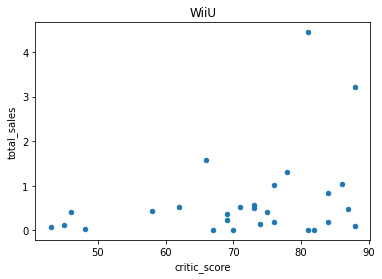

Коэффициент корреляции между продажами и оценкой критиков: 0.31704571176962204


In [38]:
popular_platform_data[popular_platform_data['platform'] == 'WiiU'].plot(kind='scatter', y='total_sales', x='critic_score', title='WiiU')
corr = popular_platform_data[popular_platform_data['platform'] == 'WiiU']['total_sales'].corr(popular_platform_data['critic_score'])
plt.show()
print(f'Коэффициент корреляции между продажами и оценкой критиков: {corr}')

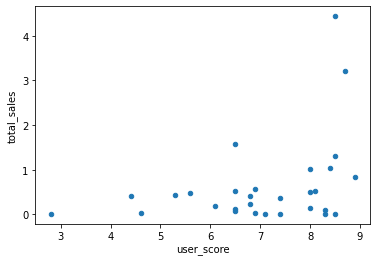

Коэффициент корреляции между продажами и оценкой игроков: 0.36351857248094444


In [39]:
popular_platform_data[popular_platform_data['platform'] == 'WiiU'].plot(kind='scatter', y='total_sales', x='user_score')
corr = popular_platform_data[popular_platform_data['platform'] == 'WiiU']['total_sales'].corr(popular_platform_data['user_score'])
plt.show()
print(f'Коэффициент корреляции между продажами и оценкой игроков: {corr}')

По графикам видно, что оценка игроков чуть сильнее коррелирует с количеством продаж, но всё же очень слабо, поэтому при продаже игр не стоит ориентироваться на оценки.

**Посмотрим, как дела обстоят на других платформах.**

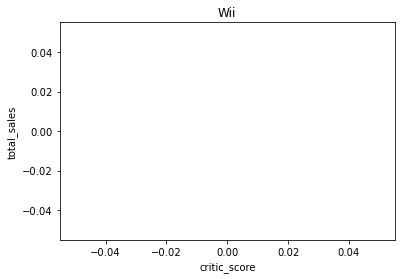

Коэффициент корреляции между продажами и оценкой критиков: nan


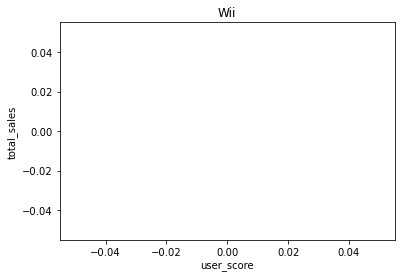

Коэффициент корреляции между продажами и оценкой игроков: nan


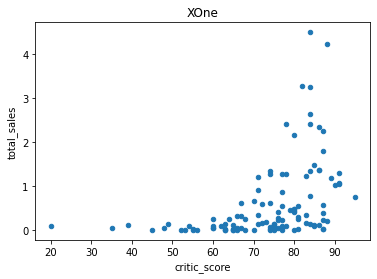

Коэффициент корреляции между продажами и оценкой критиков: 0.430888745821368


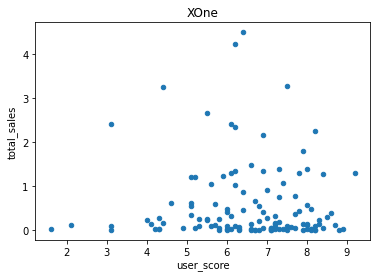

Коэффициент корреляции между продажами и оценкой игроков: -0.04146733387366271


In [40]:
platforms = ['Wii', 'XOne']
scores = ['critic_score', 'user_score']
words=['критиков', 'игроков']
word_index = 0
for platform in platforms:
    for score in scores:
        popular_platform_data[popular_platform_data['platform'] == platform].plot(kind='scatter', y='total_sales', x=score, title=platform)
        corr = popular_platform_data[popular_platform_data['platform'] == platform]['total_sales'].corr(popular_platform_data[score])
        plt.show()
        print(f'Коэффициент корреляции между продажами и оценкой {words[word_index]}: {corr}')
        word_index = (word_index + 1) % 2
        

**Для платформы Wii не получилось построить диаграмму рассеяния и вычислить корреляции. Взглянем на срез данных по этой платформе внимательнее.**

In [41]:
 display(popular_platform_data[popular_platform_data['platform'] == 'Wii'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2178,Just Dance 2016,Wii,2015,Misc,0.41,0.46,0.0,0.08,NaN,NaN,E10+,0.95
8007,Just Dance 2017,Wii,2016,Misc,0.06,0.11,0.0,0.01,NaN,NaN,E10+,0.18
8939,Skylanders: SuperChargers,Wii,2015,Action,0.02,0.12,0.0,0.01,NaN,NaN,unknown,0.15
14679,Barbie and Her Sisters Puppy Rescue,Wii,2015,Action,0.00,0.03,0.0,0.00,NaN,NaN,E,0.03
16308,Monster High: New Ghoul in School,Wii,2015,Action,0.00,0.01,0.0,0.00,NaN,NaN,E,0.01


Для платформы Wii не получилось построить диаграмму рассеяния и вычислить корреляции, так как для её игр нет оценок пользователей и критиков.

### Определение самых популярных жанров

**Посмотрим на медианные продажи игр по жанрам.**

<AxesSubplot:title={'center':'Динамика медианных продаж игр на популярных платформах по различным жанрам за 2015-2016 годы'}, xlabel='Год', ylabel='Продажи (млн.)'>

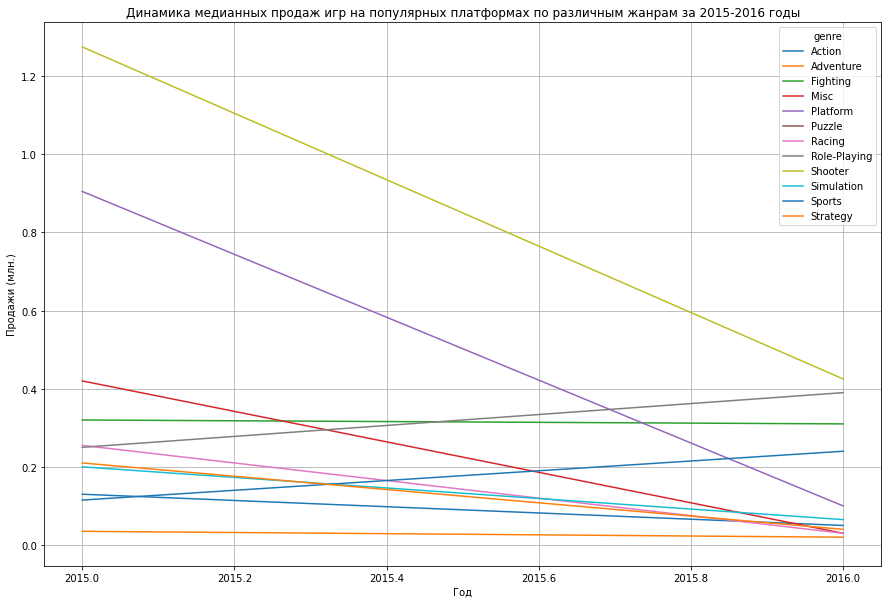

In [42]:
pd.pivot_table(popular_platform_data, index='year_of_release', columns='genre', values='total_sales', aggfunc='median')\
.plot(grid=True, figsize=(15,10), xlabel='Год', ylabel='Продажи (млн.)', title='Динамика медианных продаж игр на популярных платформах по различным жанрам за 2015-2016 годы')

In [43]:
display(popular_platform_data.groupby('genre')['total_sales'].median().sort_values(ascending=False).head(5))
display(popular_platform_data.groupby('genre')['total_sales'].median().sort_values().head(5))

genre
Shooter         0.695
Fighting        0.315
Role-Playing    0.250
Sports          0.240
Misc            0.185
Name: total_sales, dtype: float64

genre
Puzzle        0.01
Adventure     0.03
Action        0.08
Racing        0.10
Simulation    0.12
Name: total_sales, dtype: float64

Лидерами медианных значнеий продаж на популярных платформах являются игры жанров **Shooter, Fighting, Role-Playing,  Sports** и **Misc**, причём первый жанр значительно выбивается вперёд; аутсайдерами - Puzzle, Adventure, Action, Racing и Simulation. 

### Выводы

<font size=4>
    
Исследование помогло понять, что
- актуальны данные за 2015-2016 годы;
- наиболее перспективными платформами являются **WiiU, Wii** и **XOne**;
- продажи крайне слабо зависят от оценок критиков, а тем более - игроков;
- самыми популярными жанрами согласно медианным продажам являются **Shooter, Fighting, Role-Playing,  Sports** и **Misc**, причём первый жанр значительно выбивается вперёд
    
</font>

## Составление портрета пользователя по регионам

### Определение самых популярных платформ по регионам

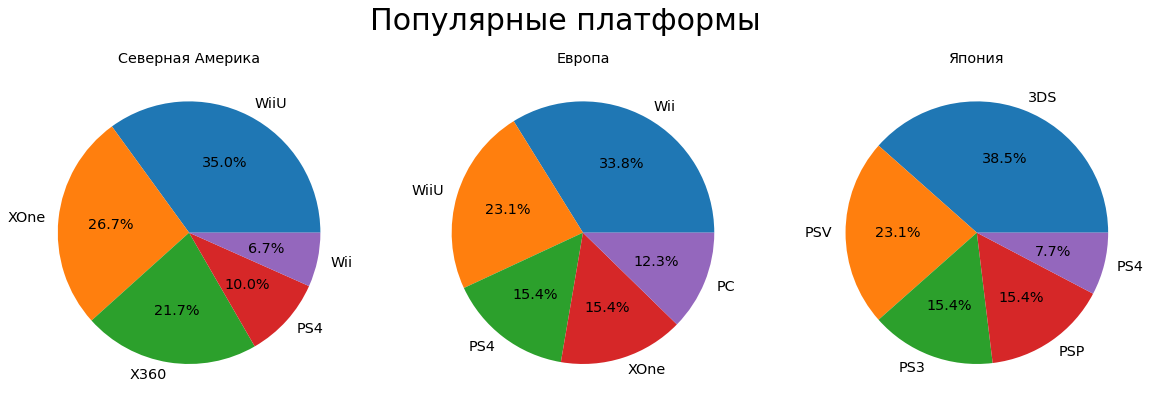

In [44]:
regions_sales = ['na_sales', 'eu_sales', 'jp_sales']
regions = ['Северная Америка', 'Европа', 'Япония']
region_index = 0
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 7)
fig.suptitle('Популярные платформы', y=0.95, fontsize=30)
for region_sales in regions_sales:
    grouped_data = data.groupby('platform')[region_sales].median().sort_values(ascending=False).head(5)
    ax[region_index].set_title(f'{regions[region_index]}', fontsize= 'x-large')
    ax[region_index].pie(grouped_data, autopct='%1.1f%%', normalize=True, labels=grouped_data.index, textprops={'size': 'x-large'}) 
    region_index = (region_index + 1) % 3
plt.show()

### Определение самых популярных жанров по регионам

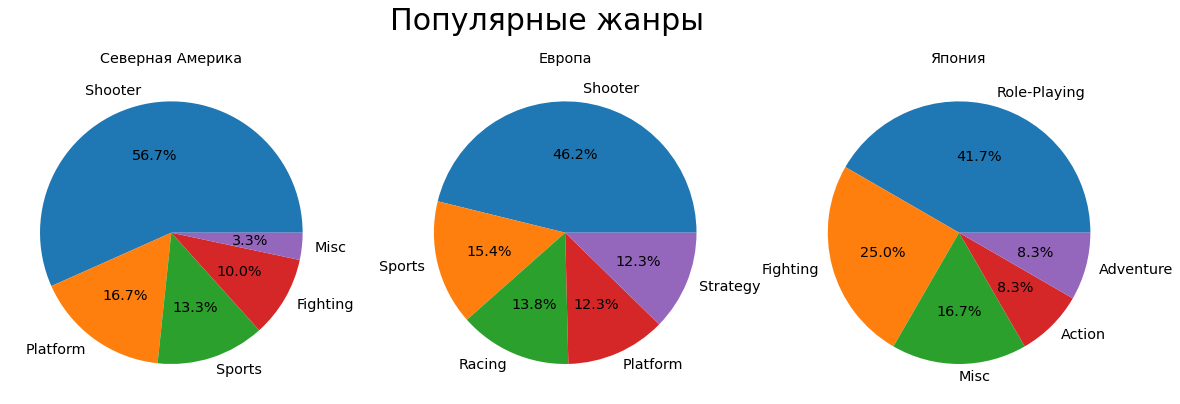

In [45]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 7)
fig.suptitle('Популярные жанры', y=0.95, fontsize=30)
for region_sales in regions_sales:
    grouped_data = data.groupby('genre')[region_sales].median().sort_values(ascending=False).head(5)
    ax[region_index].set_title(f'{regions[region_index]}', fontsize= 'x-large')
    ax[region_index].pie(grouped_data, autopct='%1.1f%%', normalize=True, labels=grouped_data.index, textprops={'size': 'x-large'}) 
    region_index = (region_index + 1) % 3
plt.show()

### Определение влияния рейтинга ESRB на продажи по регоинам

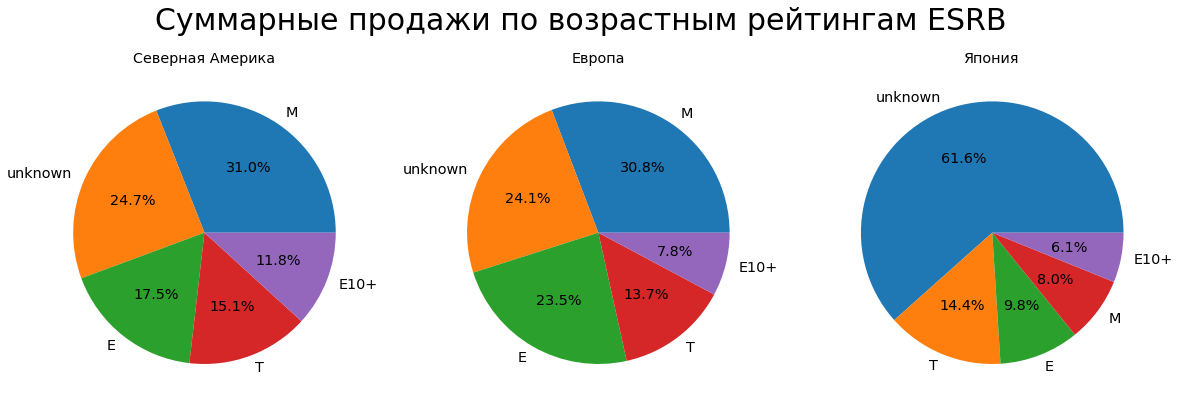

In [46]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 7)
fig.suptitle('Суммарные продажи по возрастным рейтингам ESRB', y=0.95, fontsize=30)
for region_sales in regions_sales:
    grouped_data = data.groupby('rating')[region_sales].sum().sort_values(ascending=False).head(5)
    ax[region_index].set_title(regions[region_index], fontsize= 'x-large')
    ax[region_index].pie(grouped_data, autopct='%1.1f%%', normalize=True, labels=grouped_data.index, textprops={'size': 'x-large'}) 
    region_index = (region_index + 1) % 3
plt.show()

### Выводы

<font size=4>

По графикам видны портреты игорков по регионам. Так, в Европе больше всего предпочитают консоль Wii, шутеры и игры с рейтингом M. Северная Америка отличается от Европы лишь предпочитаемой консолью — WiiU. В Японии же картина кардинально отличается: игроки любят платформу 3DS, игры жанра Role-Playing и покупают игры с неопределённым возрастным рейтингом в 61% проценте случаев.

</font>

## Проверка гипотез

**Проверим две гипотезы. Сформулируем нулевые гипотезы $H_0$ и альтернативные гипотезы $H_1$, а также подберём критерий сравнения и уровни значимости.** 

При формулировке нулевых гипотез важно помнить, что в них всегда должен присутствовать занк равенства.

Для проверки гипотез будем использовать T-критерий Стьюдента для средних значений двух независимых выборок. При этом в первом случае стоит обратить внимание на то, что на разных платформах может быть разный набор игр — дисперсии в выборках могут быть разными. Уровень значимости возьмём стандартный — 0,05.

1.  $H_0$: Средние пользовательские рейтинги платформ Xbox One и PC равны.

    $H_1$: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [47]:
results = st.ttest_ind(
    data.query('platform == "XOne"')['user_score'],
    data.query('platform == "PC"')['user_score'],
    equal_var=False
)

mean = data.query('platform == "XOne"')['user_score'].mean()
print(f'Средний пользовательский рейтинг Xbox One: {mean}')
mean = data.query('platform == "PC"')['user_score'].mean()
print(f'Средний пользовательский рейтинг PC: {mean}')

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг Xbox One: 6.54214876033058
Средний пользовательский рейтинг PC: 6.296428571428573
Не получилось отвергнуть нулевую гипотезу


2.  $H_0$: Средние пользовательские рейтинги жанров Action и Sports равны.

    $H_1$: Средние пользовательские рейтинги жанров Action и Sports не равны.

In [48]:
results = st.ttest_ind(
    data.query('genre == "Action"')['user_score'],
    data.query('genre == "Sports"')['user_score'],
)

mean = data.query('genre == "Action"')['user_score'].mean()
print(f'Средний пользовательский рейтинг игр жанра Action: {mean}')
mean = data.query('genre == "Sports"')['user_score'].mean()
print(f'Средний пользовательский рейтинг игр жанра Sports: {mean}')

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг игр жанра Action: 6.8082901554404085
Средний пользовательский рейтинг игр жанра Sports: 5.1987804878048784
Не получилось отвергнуть нулевую гипотезу


### Выводы

<font size=4>
    
Проверка гипотез статистическими критериями говорит, что
- cредние пользовательские рейтинги платформ Xbox One и PC равны,
- средние пользовательские рейтинги жанров Action и Sports равны.
    
</font>

## Общий вывод

<div style="border:solid #32a1ce 3px; padding: 40px">
    
Для работы были предоставленны данные об играх с 1980 по 2016 годы, а именно: название игры, год релиза игры, платформа, продажи в Европе, Северной Америке, Японии и других регионах, а также оценки критиков, игроков и возрастной рейтинг. Необходимо было выявить закономерности, которые определяют успешность игры и найти информацию, позволяющую предугадать потенциально популярный продукт и спланирвоать рекламные компании на 2017 год.
Работа была разбита на 5 этапов:
    
1. изучение общей информации о данных;
2. предобработка данных;
3. исследовательский анализ даных;
4. составление портрета пользователя по регионам;
5. проверка гипотез.
    
В ходе изучения общей информации о данных было установлено, что
    
- названия столбцов стилистически оформлены неверно;
- у некоторых столбцов неверный тип данных;
- в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating` были обнаружены пропуски, причём в последних трёх - существенное по сравнению с размером датафрейма количество;
- существует значительный разрыв в количестве продаж между играми, т.е. в датасете есть выбросы — это было понятно по гистограммам и описанием статистик датасета;
- явных дубликатов в датасете не было, тем не менее столбец с названиями игр вызывал подозрение.

В ходе предобработки данных
    
    - названия колонок были приведены к нижнему регистру;
    - были обработаны и удалены неявные дубликаты;
    - были изменены неверные типы данных в датафрейме;
    - в столбце `rating` пропущенные значения были заменнены на катгорию 'unknown' для дальнейшей работы с данными;
    - в столбце `rating` малочисленные категории были включены в подходящие многочисленные;
    - был добавлен столбец `total_sales` для оценки общих продаж игр по миру.
    
В ходе исследовательского анализа данных 
    
    - был определён актуальный период, данные для которого омжно использовать для прогнозирования на 2017 год;
    - было установлено, что из-за выбросов в даннных для исследования лучше использовать медианные значения продаж, а не средние или суммарные;
    - были определены потенциально прибыльные платформы, а именно: <b>WiiU, Wii, XOne</b>;
    - были определены самые популярные жанры игр на перспективных платформах, а именно: <b>Shooter, Fighting, Role-Playing,  Sports,  Misc</b>;
    - было установлено, что между медианными продажами игр и оценками пользователей или критиков нет сильной зависимости.
    
В ходе составления портрета пользователя по регионам 
    
    - для каждого региона были построены пай чарты по медианным продажам для пяти самых популярных платформ в регоне; 
    - для каждого региона были построены пай чарты по медианным продажам для пяти самых популярных жанров игр в регоине;
    - для каждого регоина были построены пай чарты по суммарным продажам игр различных рейтингов ESRB;
    - было установлено, что в Северной Америке и Европе топ-5 популярных платформ по медианным продажам, почти совпадает, при этом в Японии картина существенно отличается. Аналогичная ситуация с популярными жанрами игр в этих регионах;
    - было установлено, что во всех трёх регионах топ суммарных продаж по возрастным рейтингам игр совпадает, при этом самые значительные части занимают <b>неопределённый</b> рейтинг и рейтинг <b>M</b>, при этом в Японии доля продаж игр с неизвестным возрастным рейтингом в 2 раза превышает аналогичные доли в Европе и Северной Америке.
    
В ходе проверки гипотез было выяснено, что
    
    - cредние пользовательские рейтинги платформ Xbox One и PC равны;
    - средние пользовательские рейтинги жанров Action и Sports равны.
    
<b>Рекомендации.</b>
    
    
В 2017 году стоит сделать основную ставку на игры жанров 
- <b>Shooter, Fighting, Role-Playing,  Sports,  Misc</b>, 
    
выпускаемых на платформах 
- <b>WiiU, Wii, XOne</b>,
    
c <b>неопределённым</b> возрастным рейтингом или рейтингом <b>M</b>. 


При этом не стоит придавать сильного значения оценкам критиков и пользователей.
    
</div>